# Script for the Project

## Libraries

In [ ]:
!pip install geojson geoplot dash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 39.3 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import folium
from shapely.geometry import Point
import webbrowser as wb
import json
import geojson
import plotly.express as px
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
from dash import Dash, dcc, html, Input, Output
from math import radians, sin, cos, sqrt, atan2

In [1]:
import pandas as pd
from math import radians, sin, cos, sqrt, atan2

def haversine_distance(row, ref_lat, ref_lon):
    lat1, lon1 = radians(row['latitude']), radians(row['longitude'])
    lat2, lon2 = radians(ref_lat), radians(ref_lon)

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    R = 6371  # Radius of Earth in kilometers
    distance = R * c

    return distance

lat_lon_dict = {
    "Madrid": (40.416775, -3.703790),
    "Málaga": (36.721275, -4.421399),
    "Barcelona": (41.385063, 2.173404),
    "Sevilla": (37.389091, -5.984459),
}
def preprocess_data(city: str) -> pd.DataFrame:
    lat, lon = lat_lon_dict[city]
    df = pd.read_csv(f"{city}/listings_1.csv")
    rel_col = ['id','host_response_time','host_response_rate','host_acceptance_rate','host_is_superhost',\
           'host_neighbourhood','host_listings_count','host_total_listings_count','host_verifications',\
           'host_has_profile_pic','host_identity_verified','neighbourhood','bathrooms','bathrooms_text',\
           'latitude','longitude','room_type','number_of_reviews','accommodates',\
           'beds','price','has_availability','review_scores_rating',\
           'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',\
           'review_scores_communication','review_scores_location','review_scores_value','license',\
           'reviews_per_month']

    df = df[rel_col]
    # Filter by number_of_reviews > 5 and have a reponse_time != NaN
    df = df[(df['number_of_reviews']>5) & (~df['host_response_time'].isna()) & (~df['host_verifications'].isna())]
    df = (
        df
        # Drop the bathrooms column
        .drop(['bathrooms'], axis=1)
        # Create again the bathroom column with the information from bathrooms_text
        .assign(bathrooms=lambda x: x['bathrooms_text'].str.extract('(\d+)', expand=False).fillna(0).astype(int))
        # Drop the column bathroom_text
        .drop(['bathrooms_text'], axis=1)
        # Turn price into a float with the price
        .assign(price=lambda x: x['price'].replace({'\$': '', ',': ''}, regex=True).fillna(0).astype(float))
        # Turn the NaN values in the bed's column into 0 beds
        .assign(beds=lambda x: x['beds'].fillna(0))
        # Create a column for the distance of a room to Plaza del Sol in Madrid (37.377261, -5.986598)
        .assign(dist=lambda x: x.apply(haversine_distance, ref_lat=lat, ref_lon=lon, axis=1))
        # Turn host_response_rate and host_acceptance_rate into integers
        .assign(host_response_rate=lambda x: x['host_response_rate'].str.extract('(\d+)', expand=False).fillna(0).astype(int))
        .assign(host_acceptance_rate=lambda x: x['host_acceptance_rate'].str.extract('(\d+)', expand=False).fillna(0).astype(int))
        # Turn the column host_verification into columns host_has_email, host_has_phone and host_has_work_email
        .assign(host_has_email=lambda x: x['host_verifications'].apply(lambda lst: 'email' in lst))
        .assign(host_has_phone=lambda x: x['host_verifications'].apply(lambda lst: 'phone' in lst))
        .assign(host_has_work_email=lambda x: x['host_verifications'].apply(lambda lst: 'work_email' in lst))
        # Drop column host_verifications
        .drop(['host_verifications'], axis=1)
        # Turn host_has_profile_pic, host_identity_verified, host_is_superhost and has_availability into booleans
        .assign(host_has_profile_pic=lambda x: x['host_has_profile_pic'].apply(lambda x: 't'==x))
        .assign(host_identity_verified=lambda x: x['host_identity_verified'].apply(lambda x: 't'==x))
        .assign(host_is_superhost=lambda x: x['host_is_superhost'].apply(lambda x: 't'==x))
        .assign(has_availability=lambda x: x['has_availability'].apply(lambda x: 't'==x))
        # Turn the column licence into a boolean column has_licence
        .assign(has_license=lambda x: ~x['license'].isna())
        # Drop the column license
        .drop(['license'],axis=1)
    )
    df_s = pd.read_csv(f'{city}/listings.csv')
    # Drop the column neighbourhood
    df = df.drop(['neighbourhood'],axis=1)
    # Merge from listings_summary.csv
    df = pd.merge(df, df_s[['id', 'neighbourhood']], on='id', how='left')

    response_time_order = {
        'within an hour': 0,
        'within a few hours': 1,
        'within a day': 2,
        'a few days or more': 3
    }

    df['response_time_label'] = df['host_response_time'].map(response_time_order)
    df.drop("host_response_time", axis=1, inplace=True)

    """In addition, we will do the same thing for the column room_type"""

    room_type_order = {
        'Entire home/apt': 0,
        'Private room': 1,
        'Shared room': 2,
        'Hotel room': 3
    }
    df['room_type_label'] = df['room_type'].map(room_type_order)

    df.drop("room_type", axis=1, inplace=True)

    df.drop(["id", "host_total_listings_count", "review_scores_value", "review_scores_accuracy", "review_scores_communication", "beds", "review_scores_checkin", "latitude", "longitude"], axis=1, inplace=True)

    df["city"] = city
    return df

df = pd.concat([preprocess_data("Madrid"), preprocess_data("Málaga"), preprocess_data("Barcelona"), preprocess_data("Sevilla")]).reset_index().drop("index", axis=1)

The following command is just so that all columns appear on the representations

In [4]:
pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows',None)

## Functions

We will define some functions that we will use later.
1. haversine_distance: computes the distance between set of coordinates and a reference point given.

## Preprocessing

In [ ]:
df.isnull().sum()

id                                 0
host_response_time              5165
host_response_rate              5165
host_acceptance_rate            4080
host_is_superhost                180
host_neighbourhood             15212
host_listings_count               11
host_total_listings_count         11
host_verifications                11
host_has_profile_pic              11
host_identity_verified            11
neighbourhood                  12406
bathrooms                      25543
bathrooms_text                    15
latitude                           0
longitude                          0
room_type                          0
number_of_reviews                  0
accommodates                       0
beds                             305
price                           3809
has_availability                3809
review_scores_rating            5327
review_scores_accuracy          5330
review_scores_cleanliness       5330
review_scores_checkin           5329
review_scores_communication     5328
r

We can see there is a lot of missing data.

In [ ]:
df.count()

id                             25543
host_response_time             20378
host_response_rate             20378
host_acceptance_rate           21463
host_is_superhost              25363
host_neighbourhood             10331
host_listings_count            25532
host_total_listings_count      25532
host_verifications             25532
host_has_profile_pic           25532
host_identity_verified         25532
neighbourhood                  13137
bathrooms                          0
bathrooms_text                 25528
latitude                       25543
longitude                      25543
room_type                      25543
number_of_reviews              25543
accommodates                   25543
beds                           25238
price                          21734
has_availability               21734
review_scores_rating           20216
review_scores_accuracy         20213
review_scores_cleanliness      20213
review_scores_checkin          20214
review_scores_communication    20215
r

In [ ]:
df[(~df['host_response_time'].isna())]

,id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,...,has_availability,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,reviews_per_month
0,6369,within an hour,100%,78%,t,Hispanoamérica,1.0,1.0,"['email', 'phone']",t,...,t,4.88,4.91,4.84,4.78,4.86,4.84,4.86,NaN,0.63
3,26825,a few days or more,0%,82%,t,Legazpi,1.0,4.0,"['email', 'phone']",t,...,t,4.72,4.82,4.92,4.79,4.72,4.73,4.77,NaN,1.18
6,336834,within an hour,100%,100%,f,Justicia,1.0,1.0,"['email', 'phone']",t,...,t,4.63,4.76,4.26,4.86,4.78,4.96,4.61,NaN,0.36
7,339144,within an hour,100%,82%,t,Malasaña,2.0,5.0,['phone'],t,...,t,4.89,4.90,4.97,4.99,4.98,4.81,4.87,NaN,1.00
8,40718,within an hour,100%,100%,f,Malasaña,18.0,21.0,"['email', 'phone']",t,...,t,4.61,4.71,4.66,4.59,4.84,4.94,4.63,NaN,0.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25538,1045513235996315049,within an hour,100%,100%,f,NaN,4.0,17.0,"['email', 'phone']",t,...,t,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25539,1045517912453641702,within an hour,100%,100%,f,NaN,59.0,62.0,"['email', 'phone']",t,...,t,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25540,1045518757044319450,within an hour,100%,100%,f,NaN,59.0,62.0,"['email', 'phone']",t,...,t,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25541,1045519103468143325,within an hour,100%,100%,f,NaN,59.0,62.0,"['email', 'phone']",t,...,t,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df['neighbourhood'].isna().sum()

4915

In [ ]:
df.describe()

,id,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,number_of_reviews,accommodates,beds,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,bathrooms,dist
count,1.318600e+04,13186.000000,13186.000000,13186.000000,13186.000000,13186.000000,13186.000000,13186.000000,13186.000000,13186.000000,...,13186.000000,13186.000000,13186.000000,13186.000000,13186.000000,13186.000000,13186.000000,13186.000000,13186.000000,13186.000000
mean,3.415562e+17,96.387684,92.541938,26.142575,31.782497,40.420409,-3.694608,76.257394,3.391779,2.079782,...,4.685291,4.737181,4.716769,4.780802,4.800714,4.777421,4.605824,2.428847,1.254512,2.420460
std,3.997905e+17,12.066181,16.689571,59.234502,67.975304,0.021926,0.026432,98.336870,2.003071,1.517989,...,0.254196,0.231488,0.250606,0.212551,0.209579,0.229011,0.272816,2.031842,0.636034,2.396648
min,6.369000e+03,0.000000,0.000000,1.000000,1.000000,40.331397,-3.835330,6.000000,1.000000,0.000000,...,2.750000,2.670000,2.630000,2.860000,2.500000,2.890000,2.430000,0.050000,0.000000,0.022129
25%,2.757163e+07,100.000000,95.000000,1.000000,2.000000,40.409810,-3.707300,16.000000,2.000000,1.000000,...,4.560000,4.640000,4.600000,4.700000,4.720000,4.680000,4.490000,0.920000,1.000000,0.704414
50%,5.119802e+07,100.000000,99.000000,4.000000,5.000000,40.418690,-3.701430,39.000000,3.000000,2.000000,...,4.740000,4.790000,4.780000,4.830000,4.860000,4.860000,4.660000,1.930000,1.000000,1.289161
75%,7.629564e+17,100.000000,100.000000,16.000000,21.000000,40.427710,-3.690660,96.000000,4.000000,3.000000,...,4.870000,4.900000,4.890000,4.930000,4.940000,4.940000,4.790000,3.370000,1.000000,3.575490
max,1.030230e+18,100.000000,100.000000,566.000000,646.000000,40.535530,-3.554038,994.000000,16.000000,40.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,30.600000,10.000000,13.166324


## Plotting
Once the preprocess is done, we can plot some data and see what can we do better. Let's start plotting the boxplots for the columns 'bathrooms', 'beds', 'accommodates' and 'price'.

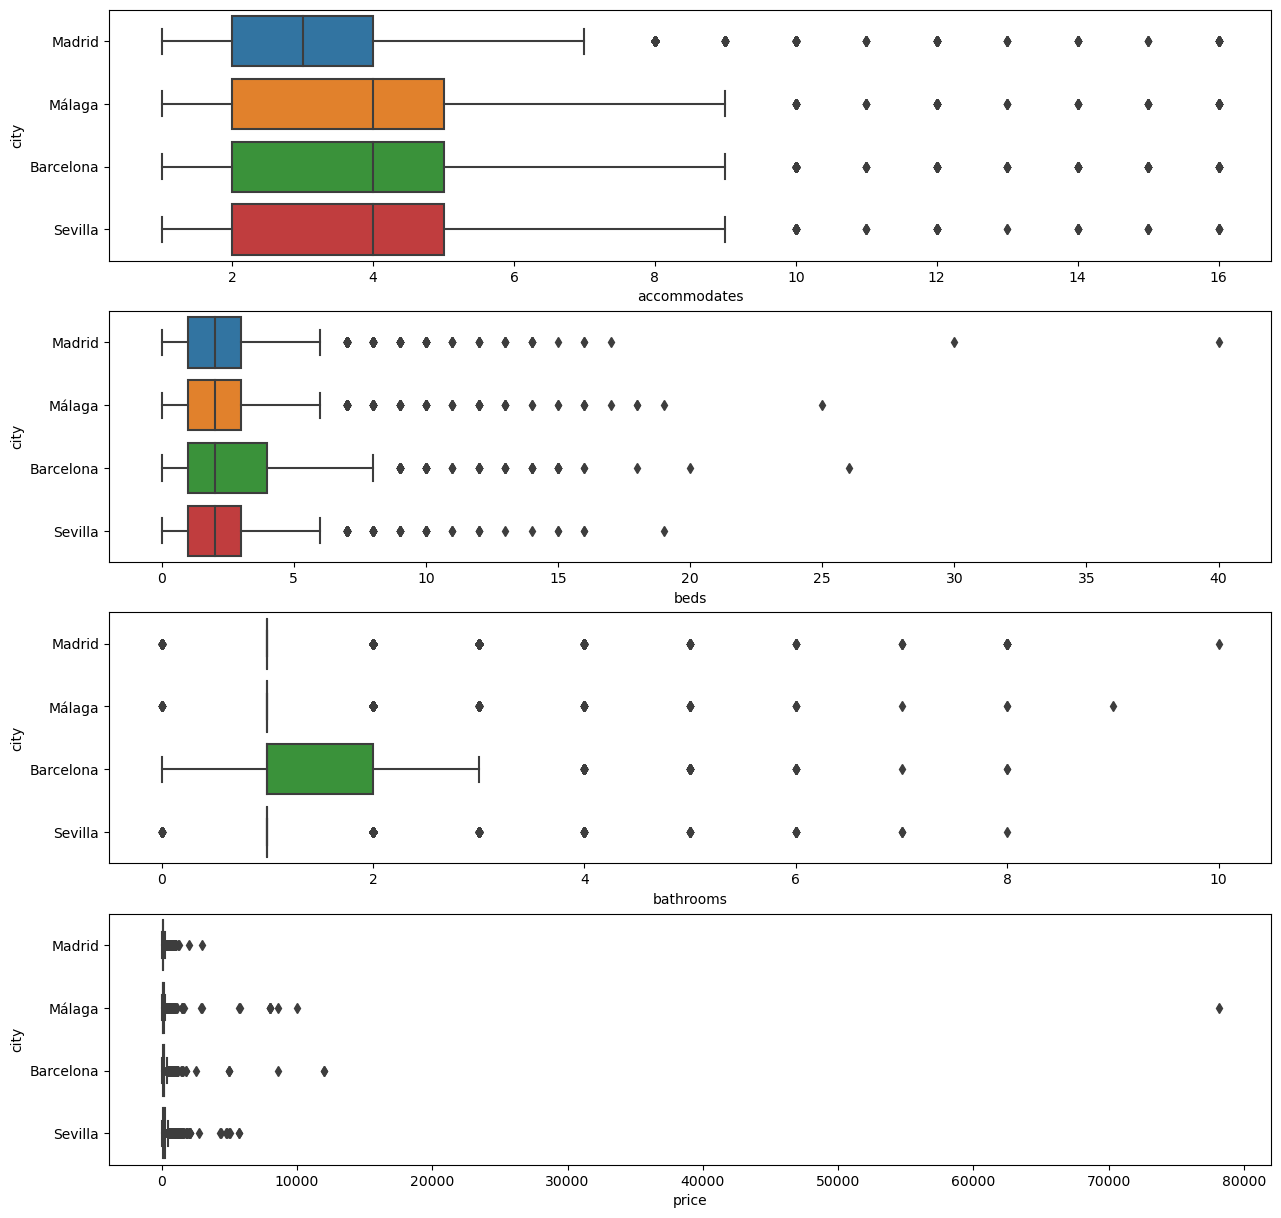

In [10]:

from matplotlib import pyplot as plt
import seaborn as sns
# Box plot for the accommodates, beds, bathrooms, price of the rooms
columns = ['accommodates', 'beds', 'bathrooms', 'price']
fig, axes = plt.subplots(nrows=len(columns))
fig.set_figheight(15)
fig.set_figwidth(15)

for c, axis in zip(columns, axes):
    sns.boxplot(y="city", x=c, data=df, ax=axis)

In [14]:

df[df["city"] == "Madrid"]

,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_has_profile_pic,host_identity_verified,number_of_reviews,accommodates,price,...,bathrooms,dist,host_has_email,host_has_phone,host_has_work_email,has_license,neighbourhood,response_time_label,room_type_label,city
0,100,78,True,Hispanoamérica,1.0,True,True,106,2,85.0,...,1,5.043051,True,True,False,False,Hispanoamérica,0,1,Madrid
1,0,82,True,Legazpi,1.0,True,True,196,1,29.0,...,1,3.218443,True,True,False,False,Legazpi,3,1,Madrid
2,100,100,False,Justicia,1.0,True,True,52,5,90.0,...,1,0.933997,True,True,False,False,Justicia,0,0,Madrid
3,100,82,True,Malasaña,2.0,True,True,142,4,65.0,...,1,1.290738,False,True,False,False,Universidad,0,0,Madrid
4,100,100,False,Malasaña,18.0,True,True,135,4,106.0,...,1,0.633536,True,True,False,False,Justicia,0,0,Madrid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13181,100,100,False,NaN,11.0,True,True,9,2,88.0,...,1,0.813336,True,True,False,False,Justicia,0,0,Madrid
13182,99,99,False,NaN,16.0,True,True,6,2,49.0,...,1,1.331226,True,True,False,False,Palos de Moguer,0,1,Madrid
13183,99,99,False,NaN,16.0,True,True,7,1,35.0,...,1,1.331226,True,True,False,False,Palos de Moguer,0,1,Madrid
13184,100,100,False,NaN,11.0,True,True,9,4,104.0,...,1,0.818887,True,True,False,False,Justicia,0,0,Madrid


In the previous plot, we see that there are several outliers in both 'bathrooms' and 'price'. For now, we will not make any changes on 'bathrooms' but we will do some outlier detection on price.

<AxesSubplot:xlabel='price', ylabel='Count'>

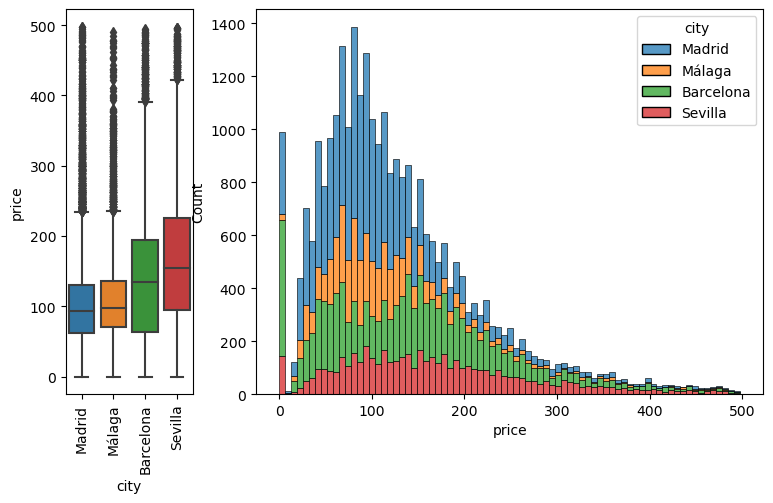

In [16]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
sns.boxplot(x="city", y="price", data=df[df['price'] < 500],ax=axes[0])
axes[0].tick_params(axis='x', labelrotation=90)
sns.histplot(data=df[df['price'] < 500], x='price',ax=axes[1], hue="city",  multiple="stack")

plt.show()

for city in ("Madrid", "Málaga", "Barcelona", "Sevilla"):
    sns.histplot(data=df[(df['price'] < 500)], x='price',ax=axes[1], hue="city",  multiple="stack")
    plt.show()


<AxesSubplot:xlabel='price', ylabel='Count'>

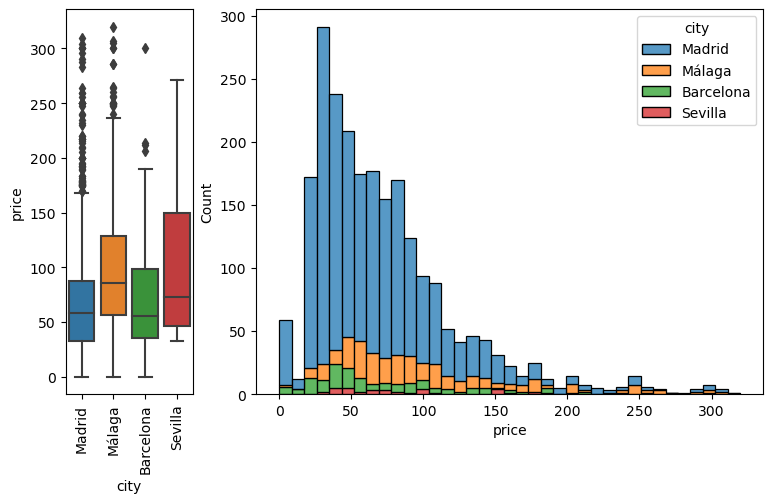

In [25]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
sns.boxplot(x="city", y="price", data=df[(df['price'] < 500) & (df["dist"] > 5)],ax=axes[0])
axes[0].tick_params(axis='x', labelrotation=90)
sns.histplot(data=df[(df['price'] < 500) & (df["dist"] > 5)], x='price',ax=axes[1], hue="city",  multiple="stack")

Let us apply the IQR technique.

In [20]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

small_outliers = df['price'] < (Q1 - 1.5 * IQR)
big_outliers = df['price'] > (Q3 + 1.5 * IQR)
sum(small_outliers), sum(big_outliers)

(0, 1689)

If we now represent again the column:

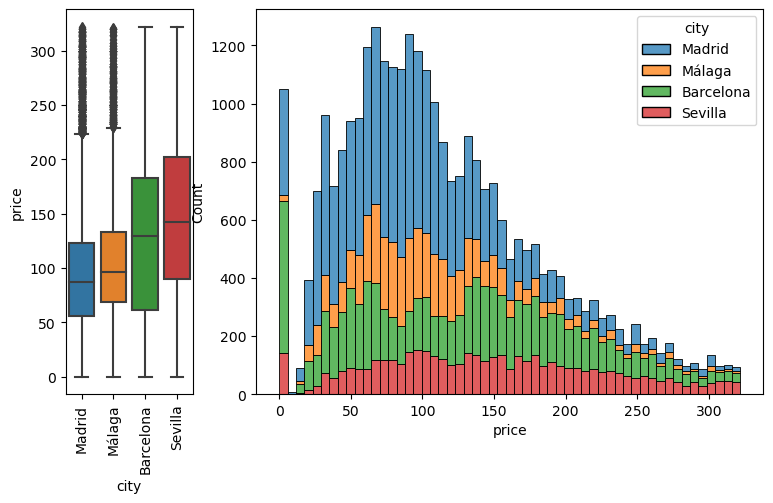

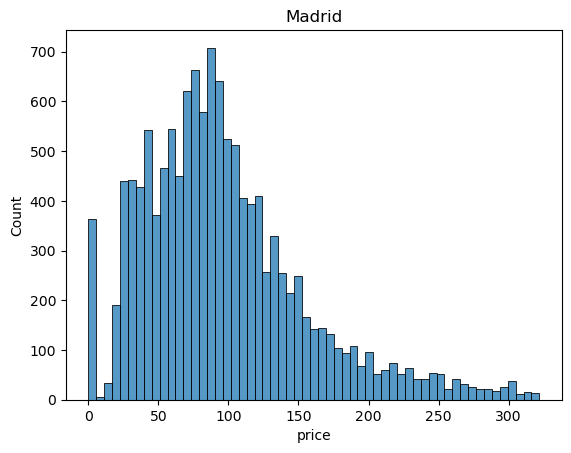

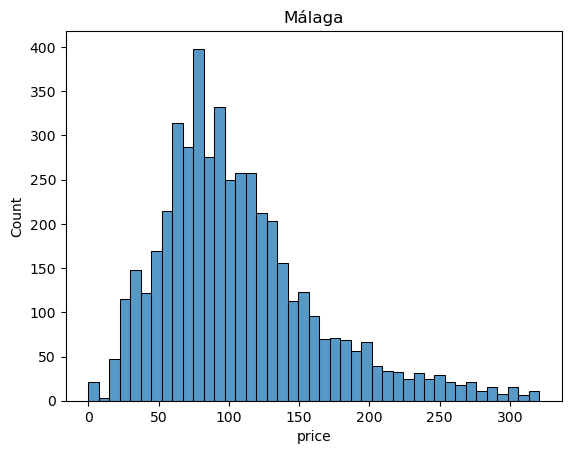

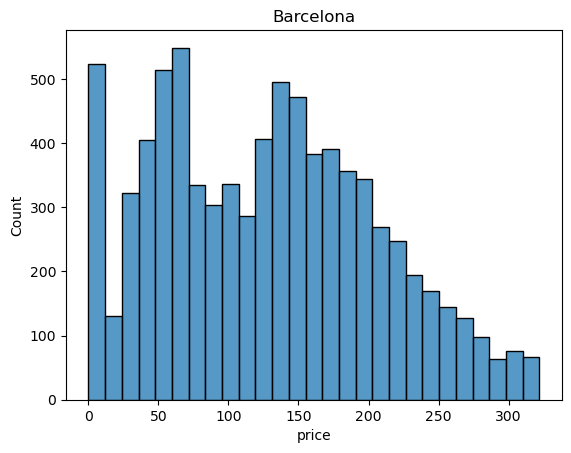

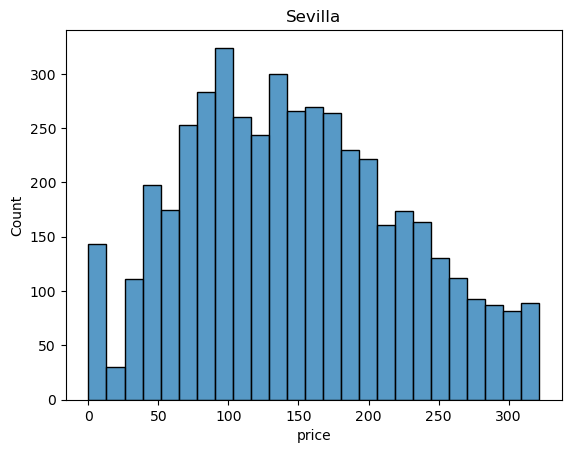

In [21]:

newdf = df[~(small_outliers | big_outliers)]
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
sns.boxplot(data=newdf,ax=axes[0], x="city", y="price")
axes[0].tick_params(axis='x', labelrotation=90)
sns.histplot(data=newdf, x='price',ax=axes[1], hue="city", multiple="stack")


plt.show()

for city in ("Madrid", "Málaga", "Barcelona", "Sevilla"):
    sns.histplot(data=newdf[newdf['city'] == city], x='price')
    plt.title(city)
    plt.show()


This looks way better than before so lets apply it to the dataframe

In [22]:
df = newdf

Let's also plot the distribution of this columns

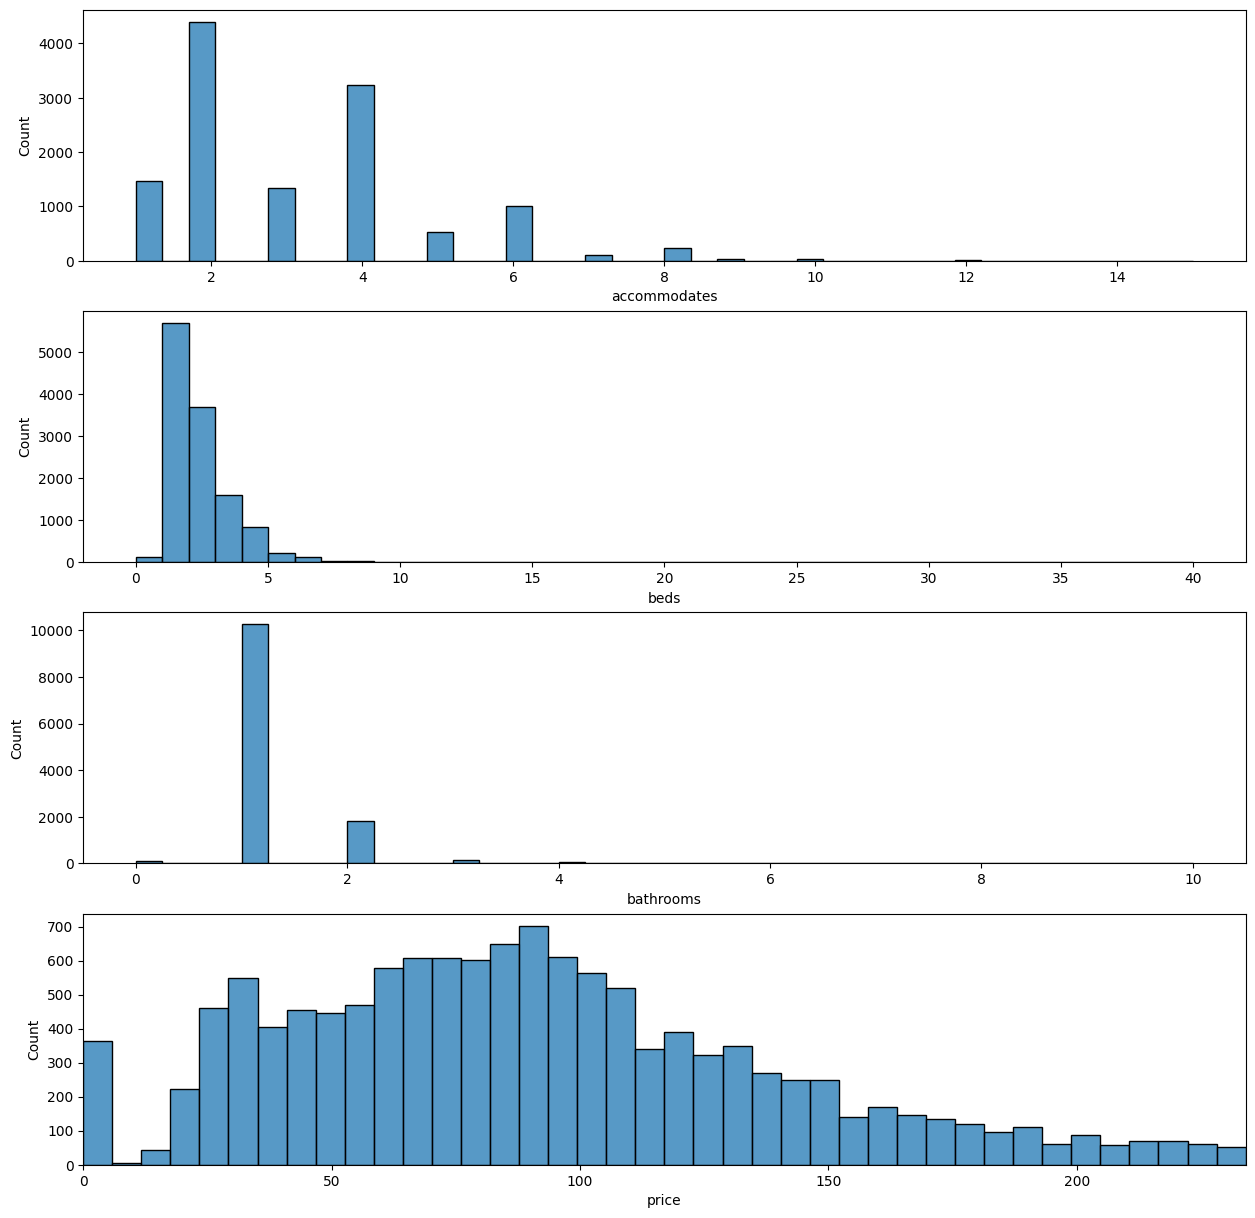

In [ ]:
fig, axes = plt.subplots(nrows=len(columns))
fig.set_figheight(15)
fig.set_figwidth(15)

for c, axis in zip(columns, axes):
    sns.histplot(data=df, x=c, ax=axis, binwidth=(df[c].max()-df[c].min())/40.0)
    plt.xlim(df[c].min(),df[c].max())


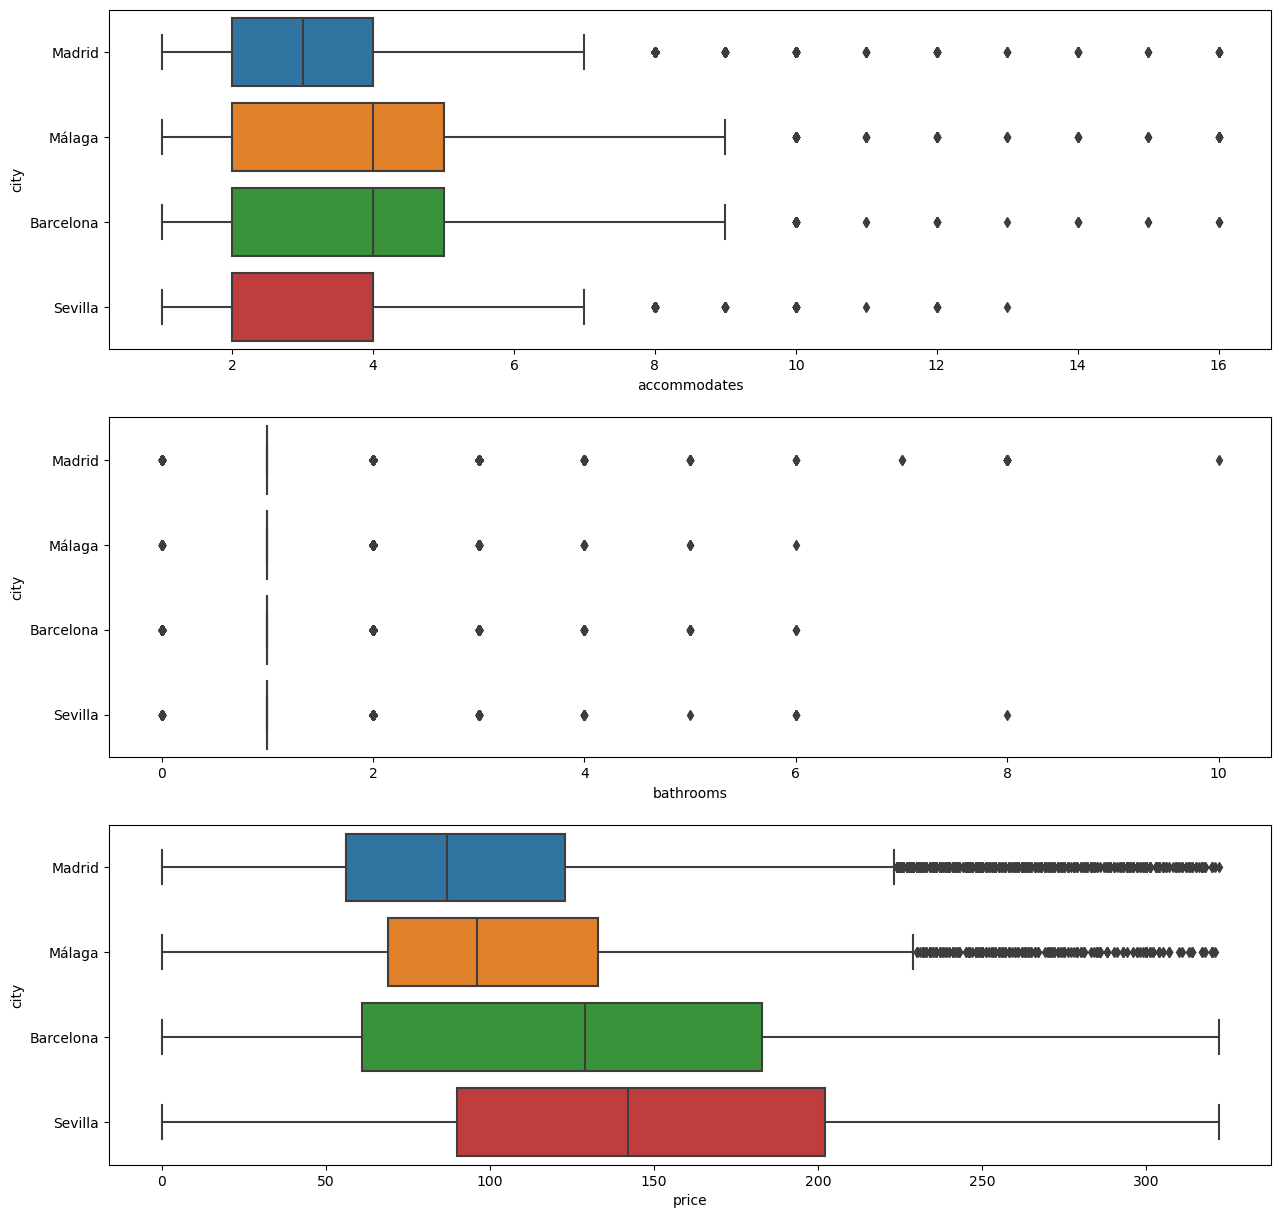

In [23]:
columns = ['accommodates', 'bathrooms', 'price']
fig, axes = plt.subplots(nrows=len(columns))
fig.set_figheight(15)
fig.set_figwidth(15)

for c, axis in zip(columns, axes):
    sns.boxplot(y="city", x=c, data=df, ax=axis)

It is interesting to check the correlation between the numerical columns.

<AxesSubplot:>

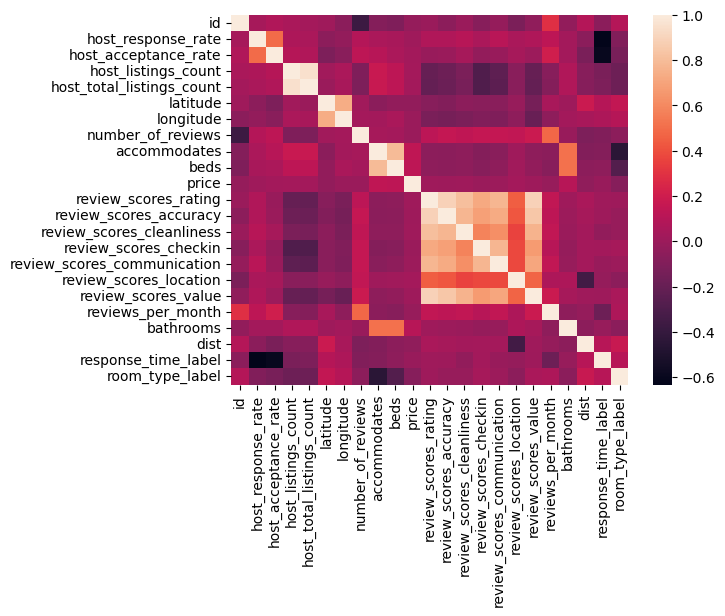

In [149]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
newdf = df.select_dtypes(include=numerics)
sns.heatmap(newdf.corr())

In case we want to check the correlation more precisely:

In [150]:
def corrank(X: pd.DataFrame):
    import itertools
    df_corr = pd.DataFrame([[(i,j),X.corr().loc[i,j]] for i,j in list(itertools.combinations(X.corr(), 2))],columns=['pairs','corr'])
    return df_corr.sort_values(by='corr',ascending=False)

In [151]:
a = corrank(newdf)

In [152]:
correl = a.set_index("pairs").to_dict()["corr"]

We will show only the data with correlation greater than 0.7 so that we can see the most relevant correlations.

In [153]:
{key: value for key, value in correl.items() if value > 0.7}

{('host_listings_count', 'host_total_listings_count'): 0.9528042202507714,
 ('review_scores_rating', 'review_scores_accuracy'): 0.8864399198774596,
 ('review_scores_rating', 'review_scores_value'): 0.8860886840139696,
 ('review_scores_accuracy', 'review_scores_value'): 0.8465669985476595,
 ('review_scores_rating', 'review_scores_cleanliness'): 0.8113450789164287,
 ('accommodates', 'beds'): 0.7953544095373143,
 ('review_scores_checkin', 'review_scores_communication'): 0.7757402459633217,
 ('review_scores_accuracy', 'review_scores_cleanliness'): 0.7744068523588018,
 ('review_scores_rating', 'review_scores_communication'): 0.7709866273502104,
 ('review_scores_cleanliness', 'review_scores_value'): 0.759454038106435,
 ('latitude', 'longitude'): 0.7365525686303688,
 ('review_scores_accuracy', 'review_scores_communication'): 0.7262918591453557,
 ('review_scores_rating', 'review_scores_checkin'): 0.7201966742864219,
 ('review_scores_communication', 'review_scores_value'): 0.7113592117135117}

In [60]:
# Remove very similar columns
df.drop(["host_total_listings_count", "review_scores_value", "review_scores_accuracy", "review_scores_communication", "beds", "review_scores_checkin"], axis=1, inplace=True)

## Geographycal information
Let us first of all read the files with data about the neighbourhoods and their geometry.

In [ ]:
# Data about the neighbourhoods
neig_csv = pd.read_csv('drive/MyDrive/neighbourhoods.csv')
# Geojson with the geometry of the neighbourhoods
with open('neighbourhoods.geojson') as f:
    gj = geojson.load(f)
# Geojson converted to dataframe
df_n = gpd.read_file('neighbourhoods.geojson')

With this data we can plot the amount of rooms per neighbourhood.

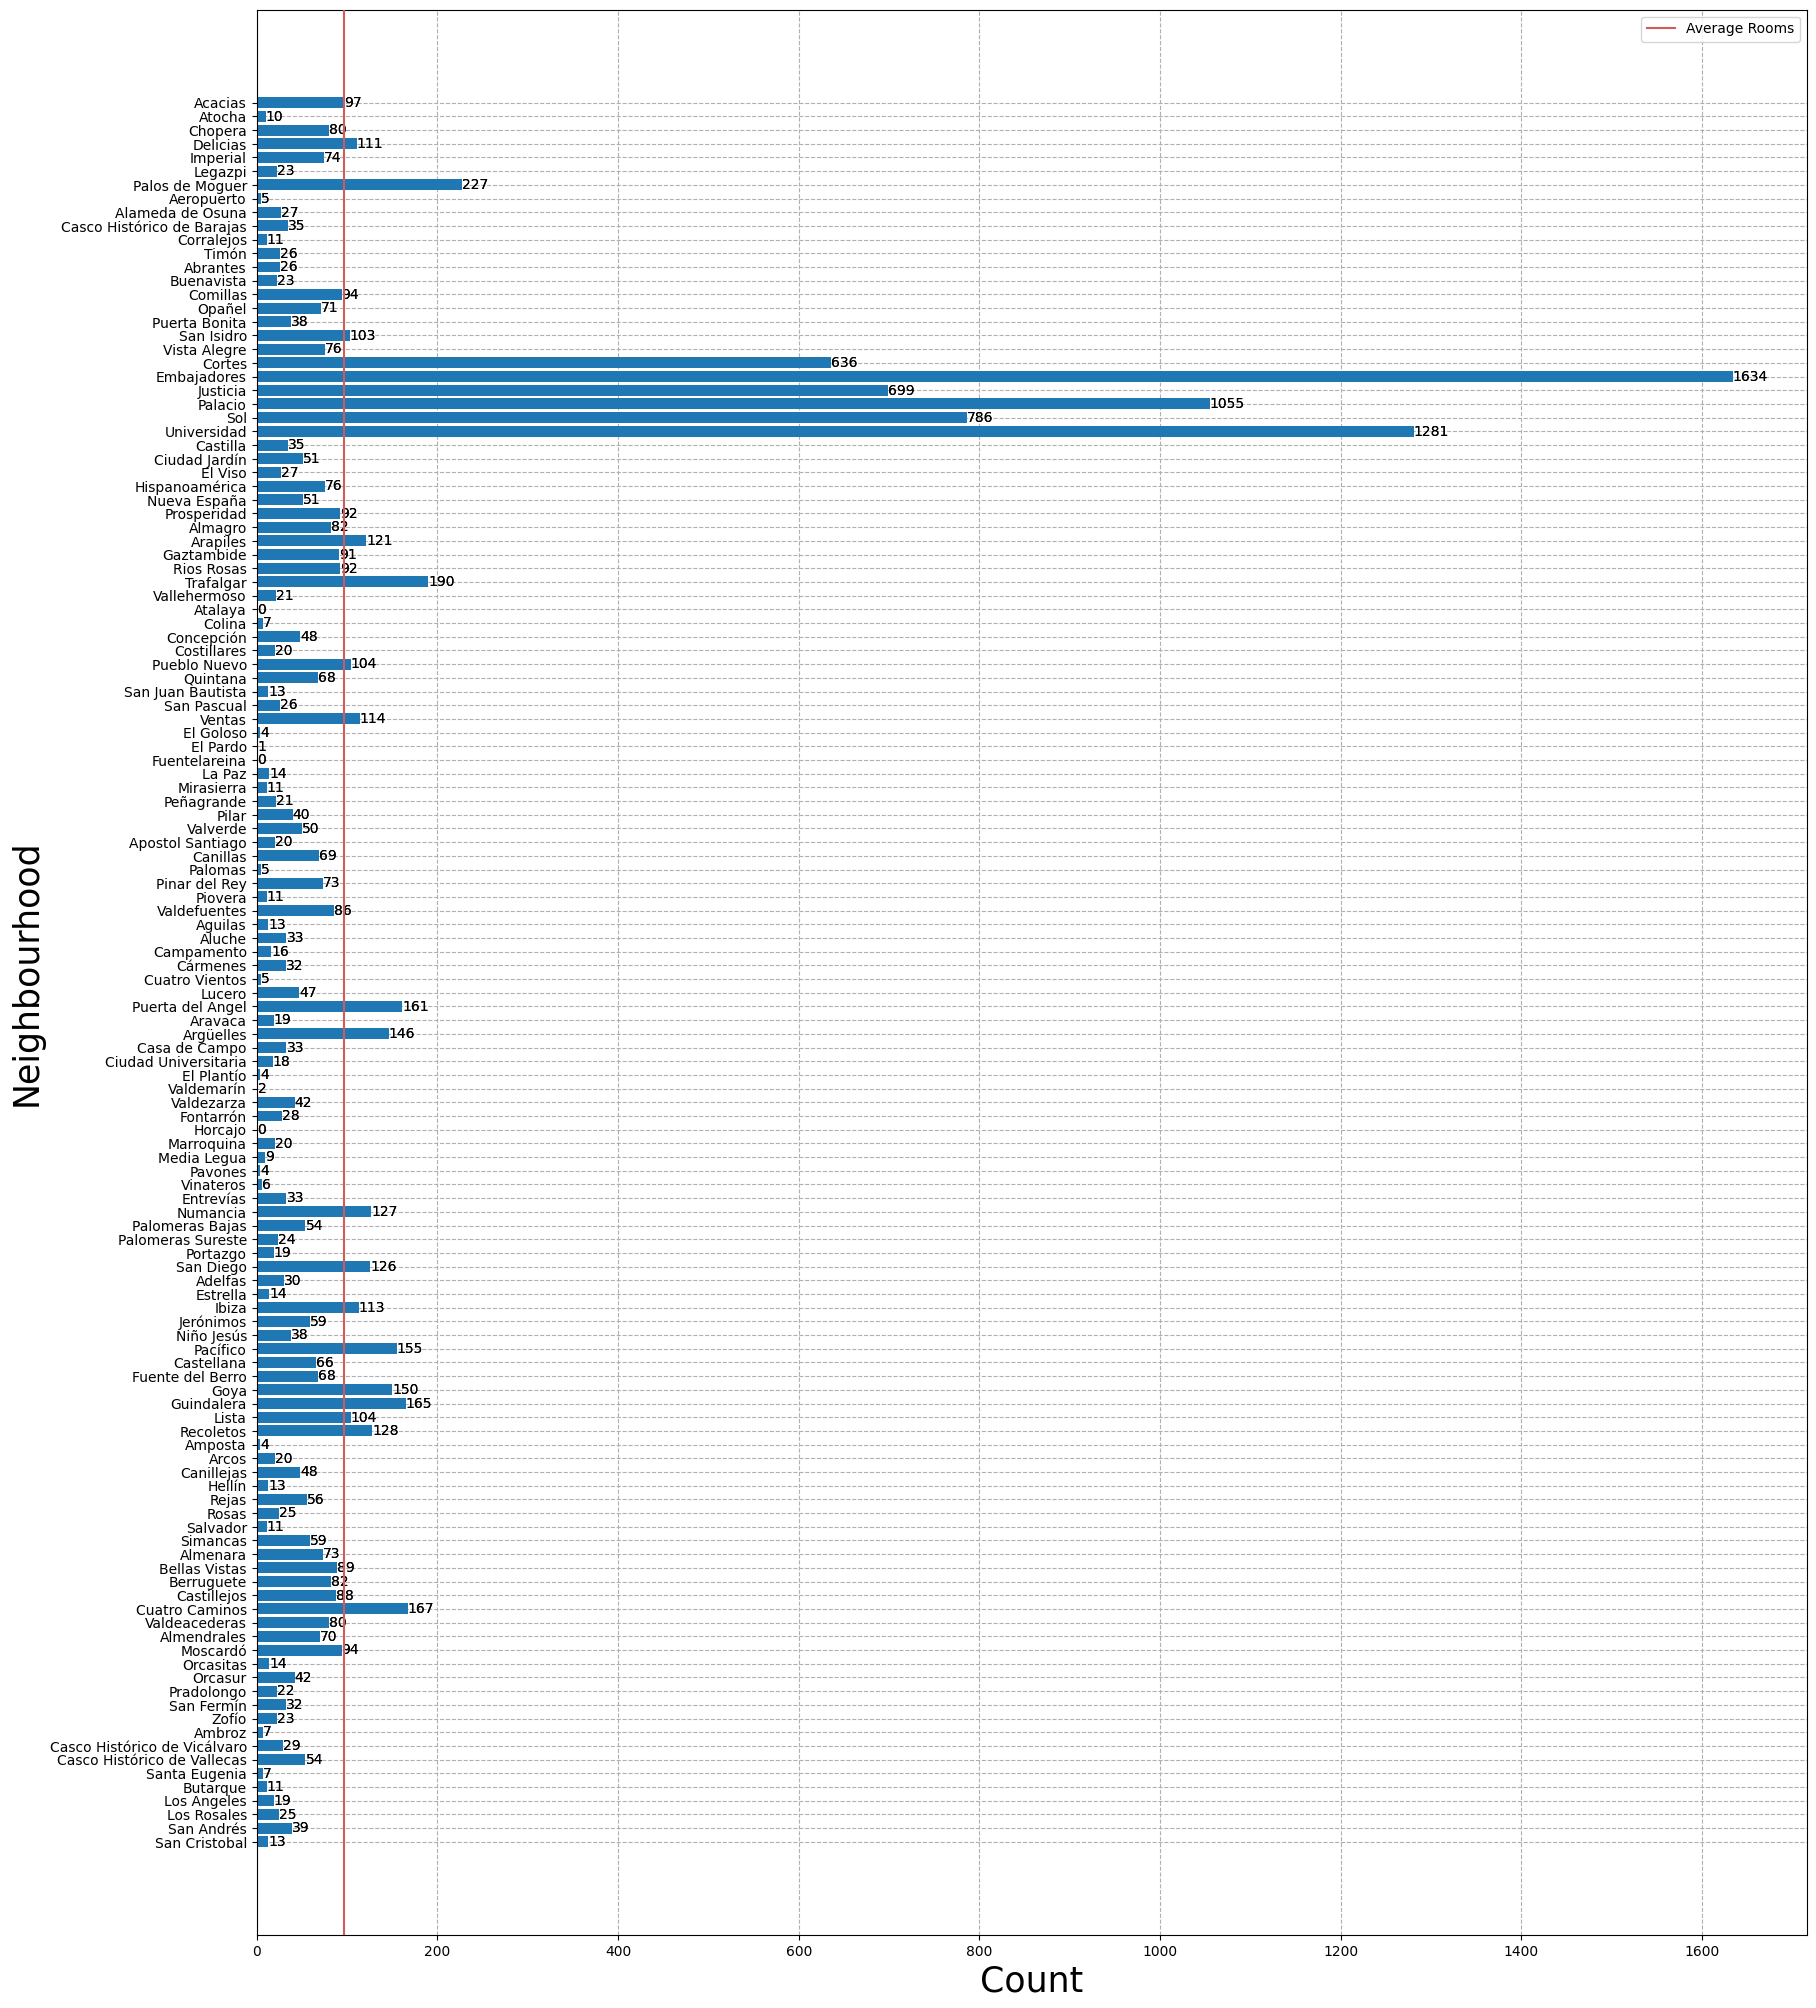

In [ ]:
# Create a df with the neighbourhoods and the count of rooms on it
dict_ = {'neighbourhood': [], 'count': []}
result = pd.DataFrame(dict_)

for neighbourhood in neig_csv["neighbourhood"]:
    count = (df['neighbourhood'] == neighbourhood).sum()
    df2 = {'neighbourhood': neighbourhood, 'count': count}
    result = pd.concat([result, pd.DataFrame([df2])], ignore_index=True)

# Representation of the number of rooms per neighbourhood
y = result.loc[:,"neighbourhood"]
width = result.loc[:,"count"]

fig,ax = plt.subplots()
fig.set_size_inches(20, 25, forward=True)

bars = ax.barh(y,width,align='center',zorder=2) # Adds labels to the bars showing the name of the neighbourhoods
labels_text = ax.bar_label(bars)
ax.invert_yaxis()
ax.grid(linestyle='--',zorder=0)

for container in ax.containers:
    ax.bar_label(container)
plt.yticks(y)
plt.axvline(np.average(width), color='#d15a5a',label="Average Rooms",zorder=3)  # Adds a vertical line representing the average rooms
plt.legend()
plt.ylabel("Neighbourhood",fontsize=25)
plt.xlabel("Count",fontsize=25)
plt.show()

Let's do the same thing but with the average price on every neighbourhood

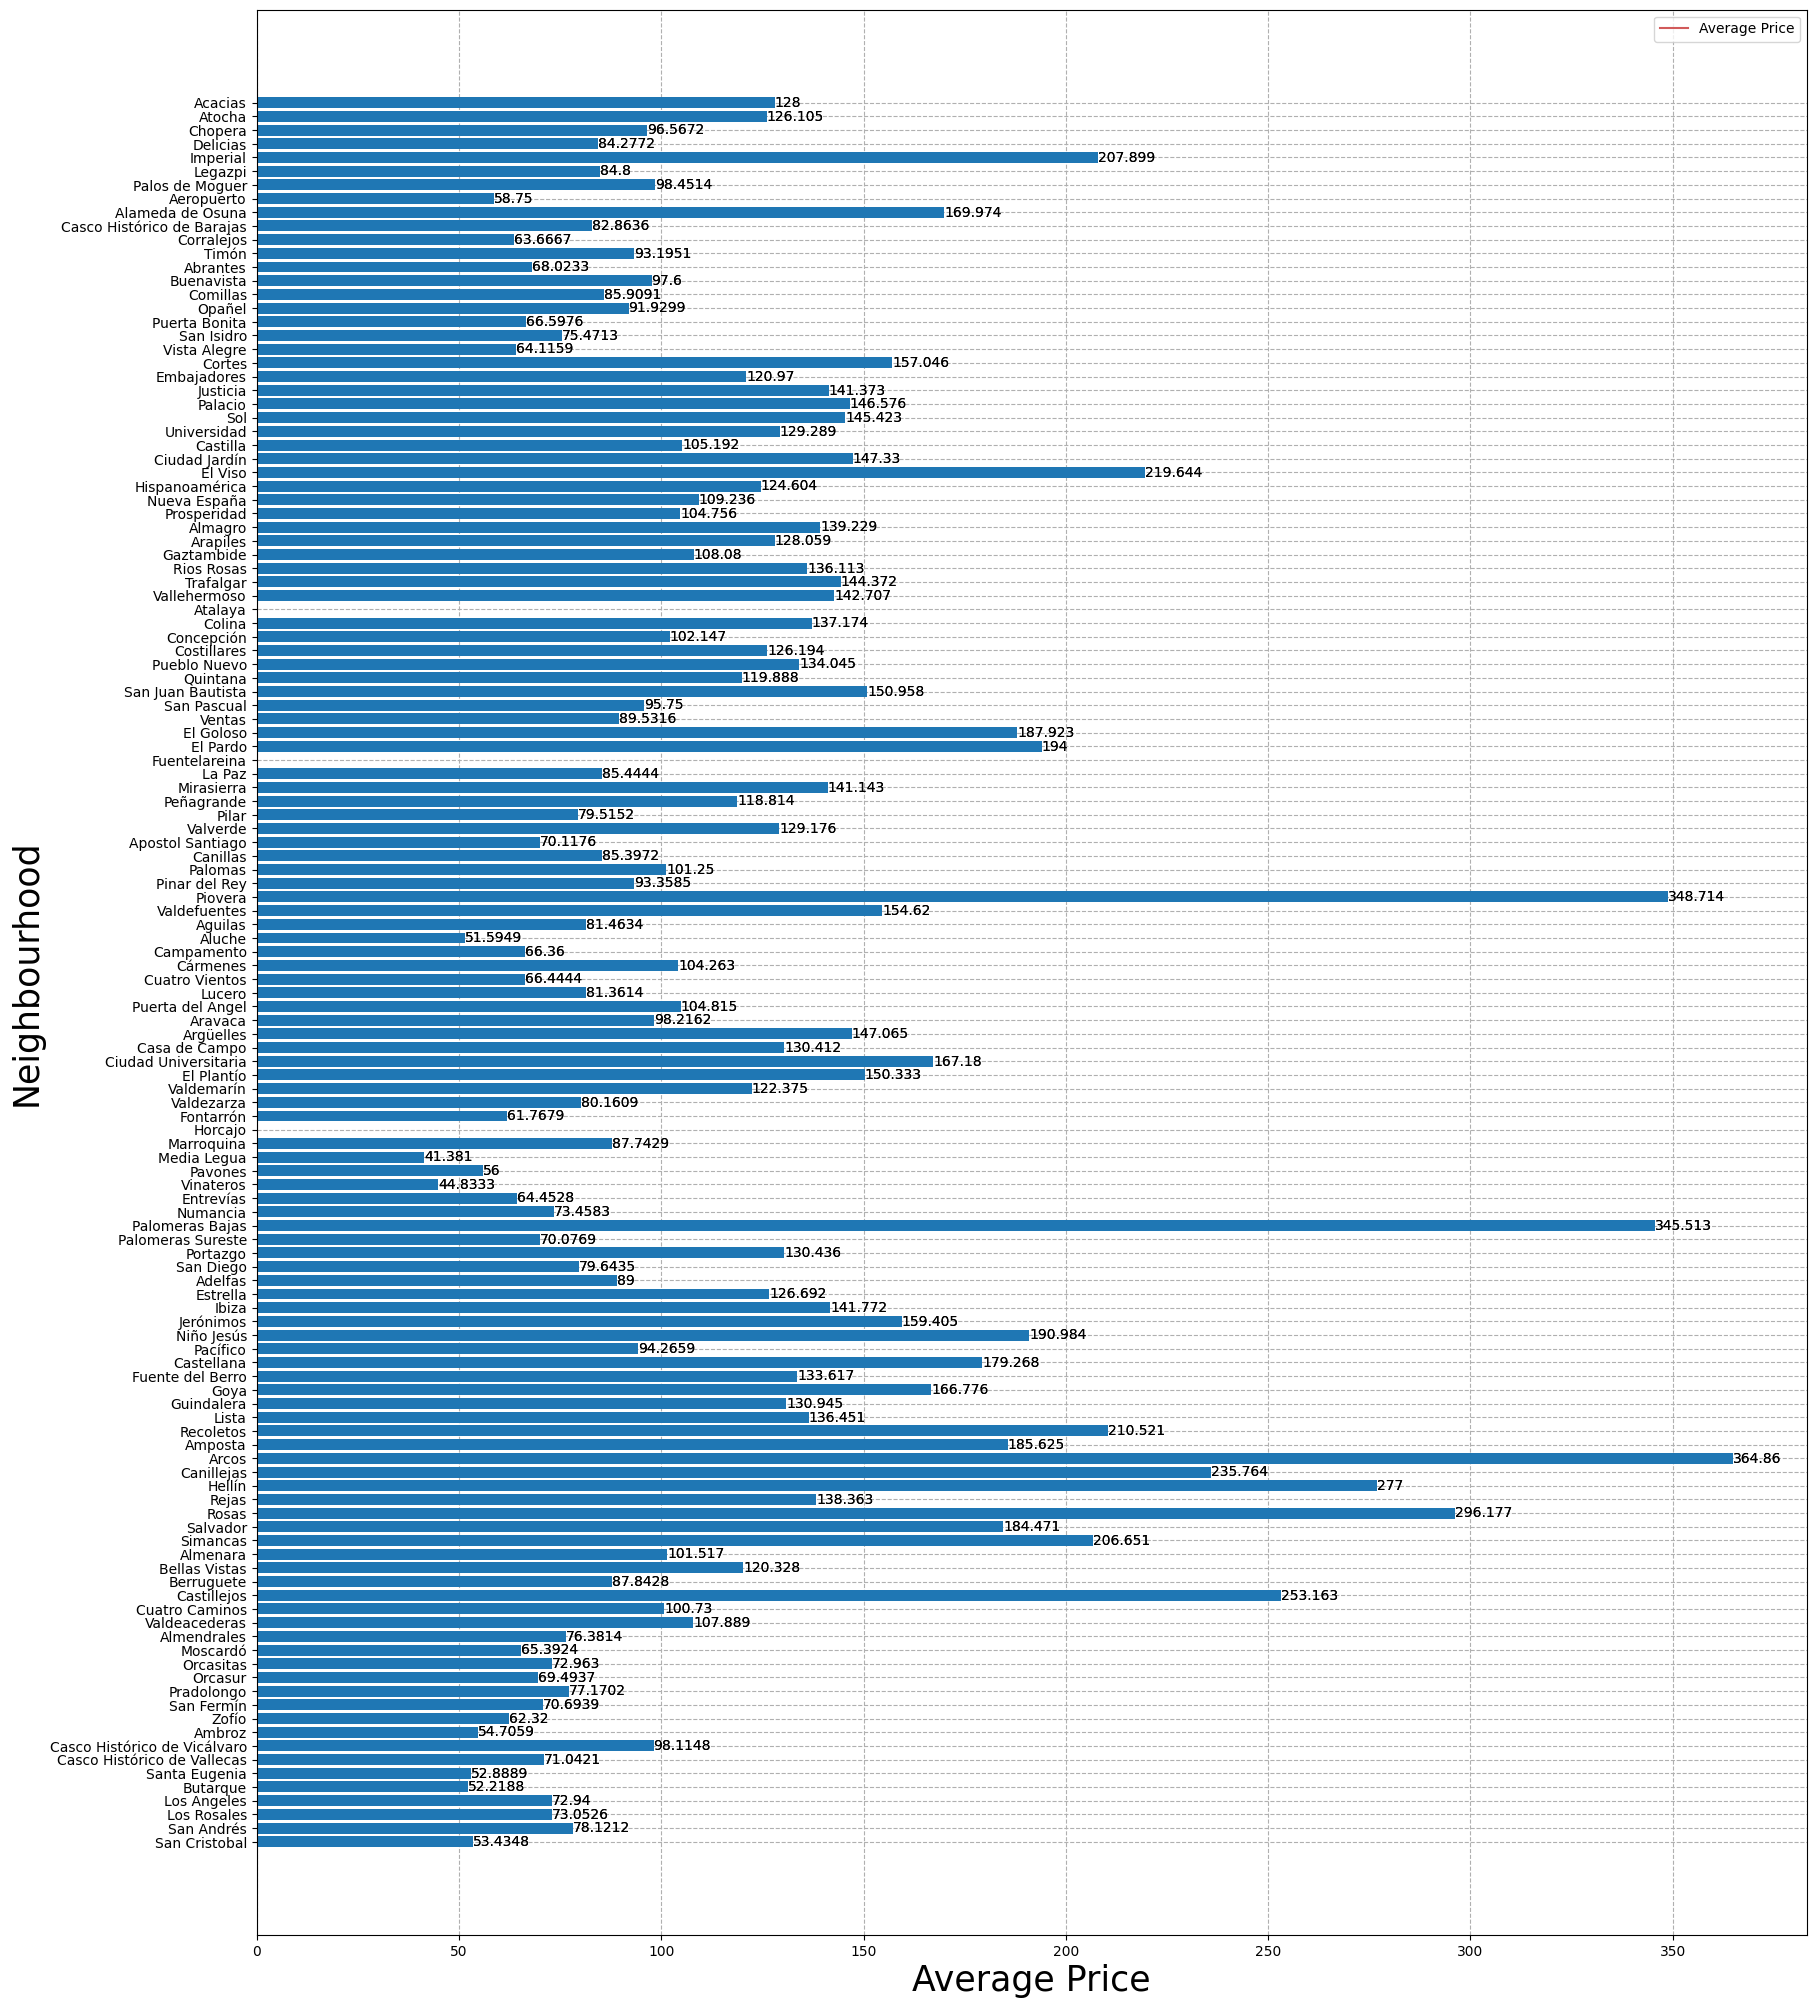

In [ ]:
# Create a df with the neighbourhoods and the count of rooms on it
dict = {'neighbourhood': [], 'avg_price': []}
result = pd.DataFrame(dict)

for neighbourhood in neig_csv["neighbourhood"]:
    avg_price = (df_s.loc[df_s['neighbourhood'] == neighbourhood, 'price']).mean()
    df2 = {'neighbourhood': neighbourhood, 'avg_price': avg_price}
    result = pd.concat([result, pd.DataFrame([df2])], ignore_index=True)

# Representation of the number of rooms per neighbourhood
y = result.loc[:,"neighbourhood"]
width = result.loc[:,"avg_price"]

fig,ax = plt.subplots()
fig.set_size_inches(20, 25, forward=True)

bars = ax.barh(y,width,align='center',zorder=2) # Adds labels to the bars showing the name of the neighbourhoods
labels_text = ax.bar_label(bars)
ax.invert_yaxis()
ax.grid(linestyle='--',zorder=0)

for container in ax.containers:
    ax.bar_label(container)
plt.yticks(y)
plt.axvline(width.mean(), color='#d15a5a',label="Average Price",zorder=3)  # Adds a vertical line representing the average rooms
plt.legend()
plt.ylabel("Neighbourhood",fontsize=25)
plt.xlabel("Average Price",fontsize=25)
plt.show()

Something is going on here cause the code is not plotting the total average price.

Let's also create a choropleth that shows this same data in a map of Sevilla.

In [ ]:
# Create a dataframe with the amount of Airbnbs per neighbourhood and the average price
dict = {'neighbourhood': [], 'count': [], 'avg_price': [], 'geometry': []}
result = pd.DataFrame(dict)

for index, row in df_n.iterrows():
    avg_price = (df.loc[df['neighbourhood'] == row["neighbourhood"], 'price']).mean()
    count = (df['neighbourhood'] == row["neighbourhood"]).sum()
    df2 = {'neighbourhood': row["neighbourhood"], 'count': count, 'avg_price': avg_price, 'geometry': row["geometry"]}
    result = pd.concat([result, pd.DataFrame([df2])], ignore_index=True)

# Represent the count of Airbnbs and the average price of them per neighbourhood

app = Dash(__name__)


app.layout = html.Div([
    html.H4('Choropleth map for Sevilla'),
    html.P("Select a feature:"),
    dcc.RadioItems(
        id='feature',
        options=["count", "avg_price"],
        value="count",
        inline=True
    ),
    dcc.Graph(id="graph"),
])


@app.callback(
    Output("graph", "figure"),
    Input("feature", "value"))
def display_choropleth(feature):
    fig = px.choropleth(
        result,                     # DataFrame containing the data to be plotted
        geojson=gj,       # GeoJSON object containing geometry information for the map
        locations='neighbourhood',       # Column in 'df' that specifies the location to match with geojson
        featureidkey="properties.neighbourhood",
        color=feature,          # Column in 'df' used to determine the color of each geographic region
        color_continuous_scale="Viridis",  # Color scale for the choropleth map
        center = {"lat": 40.41712241701609, "lon": -3.7031186230961546},            # Center of the image, eg. the coordinates of sevilla
        labels={'count': 'count of Airbnb'}  # Custom labels for the legend and hover information
    )
    fig.update_geos(fitbounds="locations", visible=False)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

    return fig

app.run_server(debug=True)

<IPython.core.display.Javascript object>

In [62]:
df

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_has_profile_pic,host_identity_verified,room_type,number_of_reviews,accommodates,price,has_availability,review_scores_rating,review_scores_cleanliness,review_scores_location,reviews_per_month,bathrooms,dist,host_has_email,host_has_phone,host_has_work_email,has_license,neighbourhood,city
0,within an hour,100,78,True,Hispanoamérica,1.0,True,True,Private room,106,2,85.0,True,4.88,4.84,4.84,0.63,1,4.983032,True,True,False,False,Hispanoamérica,Madrid
1,a few days or more,0,82,True,Legazpi,1.0,True,True,Private room,196,1,29.0,True,4.72,4.92,4.73,1.18,1,3.234847,True,True,False,False,Legazpi,Madrid
2,within an hour,100,100,False,Justicia,1.0,True,True,Entire home/apt,52,5,90.0,True,4.63,4.26,4.96,0.36,1,0.866000,True,True,False,False,Justicia,Madrid
3,within an hour,100,82,True,Malasaña,2.0,True,True,Entire home/apt,142,4,65.0,True,4.89,4.97,4.81,1.00,1,1.252100,False,True,False,False,Universidad,Madrid
4,within an hour,100,100,False,Malasaña,18.0,True,True,Entire home/apt,135,4,106.0,True,4.61,4.66,4.94,0.83,1,0.564951,True,True,False,False,Justicia,Madrid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32016,within an hour,100,100,True,NaN,5.0,True,True,Entire home/apt,6,3,102.0,True,4.67,4.83,4.83,4.74,1,389.442820,True,True,False,True,San Gil,Sevilla
32017,within an hour,100,100,True,NaN,10.0,True,True,Entire home/apt,8,4,116.0,True,4.88,4.83,5.00,6.00,1,390.826181,True,True,True,True,Santa Cruz,Sevilla
32018,within an hour,100,95,False,NaN,1.0,True,False,Private room,7,2,60.0,True,5.00,5.00,5.00,4.88,1,390.633009,False,True,False,True,La Florida,Sevilla
32019,within an hour,94,94,False,NaN,2.0,True,True,Private room,8,2,51.0,True,4.13,4.17,4.50,8.00,1,386.144212,True,True,False,True,no asignado,Sevilla


In [193]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.stats import expon, reciprocal
# import xgboost

oho = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

# _ = df["neighbourhood"].value_counts().cumsum() / len(df)
# values_to_keep = _[_ < 0.99].index

# df_to_train = df[df["neighbourhood"].isin(values_to_keep)].drop("host_neighbourhood", axis=1)
df_to_train = df[df["city"] == "Madrid"]
X_num = df_to_train.select_dtypes(exclude='object')
X_cat = df_to_train.drop(["host_neighbourhood", "city"], axis=1).select_dtypes(include='object')

post_x = oho.fit_transform(X_cat)
categorical_columns = [f'{col}_{cat}' for i, col in enumerate(X_cat.columns) for cat in oho.categories_[i]]
# put the features into a dataframe and join with the original
one_hot_features = pd.DataFrame(post_x, columns=categorical_columns)
new_df = pd.concat([X_num.reset_index(drop=True), one_hot_features], axis=1, join="inner")

l = [
    ("lm", LinearRegression(n_jobs=-1), {'lm__n_jobs': [-1]}),
    ("svr", SVR(), {
        'svr__kernel': ['rbf', "linear"],
        # "svr__C": [1, 10, 100, 1000],
    }),
    ("rfr", RandomForestRegressor(random_state=42, n_jobs=-1), {
        # 'rfr__n_estimators': [100, 1000],
        # 'rfr__max_depth': [None, 1, 10],
        'rfr__min_samples_split': [2, 30]
    }),
    ("gbt", GradientBoostingRegressor(random_state=42), {
    #    'gbt__max_depth': [50, 100, 200],
       'gbt__max_features': [2, 3],
    #    'gbt__min_samples_leaf': [3, 5, 8],
    #    'gbt__n_estimators': [100, 500, 1000]
    })
]
results = {}
for classifier_id, classifier, parameters in l:
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        # ('pca', PCA(0.99)),
        (classifier_id, classifier)
    ], verbose=2)
    random_search = GridSearchCV(
        estimator=pipe,
        param_grid=parameters,
        cv=5,
        n_jobs=-1,
        verbose=3,
    )

    random_search.fit(new_df.drop(["price"], axis=1), new_df["price"])

    results[classifier.__class__.__name__] = random_search.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\david\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.3s
[Pipeline] ................ (step 2 of 2) Processing lm, total=   0.3s
Fitting 5 folds for each of 2 candidates, totalling 10 fits


c:\Users\david\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing svr, total=  40.9s
Fitting 5 folds for each of 2 candidates, totalling 10 fits


c:\Users\david\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing rfr, total=  17.7s
Fitting 5 folds for each of 2 candidates, totalling 10 fits


c:\Users\david\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing gbt, total=   0.8s


In [24]:
results

NameError: name 'results' is not defined

In [197]:
random_search.cv_results_

{'mean_fit_time': array([1.06693997, 1.09671202]),
 'std_fit_time': array([0.08576987, 0.24728479]),
 'mean_score_time': array([0.10283785, 0.08171468]),
 'std_score_time': array([0.00844872, 0.02313562]),
 'param_gbt__max_features': masked_array(data=[2, 3],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'gbt__max_features': 2}, {'gbt__max_features': 3}],
 'split0_test_score': array([0.29202572, 0.3905571 ]),
 'split1_test_score': array([0.20340228, 0.3026496 ]),
 'split2_test_score': array([0.18983679, 0.29484088]),
 'split3_test_score': array([0.2613721 , 0.39603758]),
 'split4_test_score': array([0.31258515, 0.47923973]),
 'mean_test_score': array([0.25184441, 0.37266498]),
 'std_test_score': array([0.04813801, 0.06809307]),
 'rank_test_score': array([2, 1])}

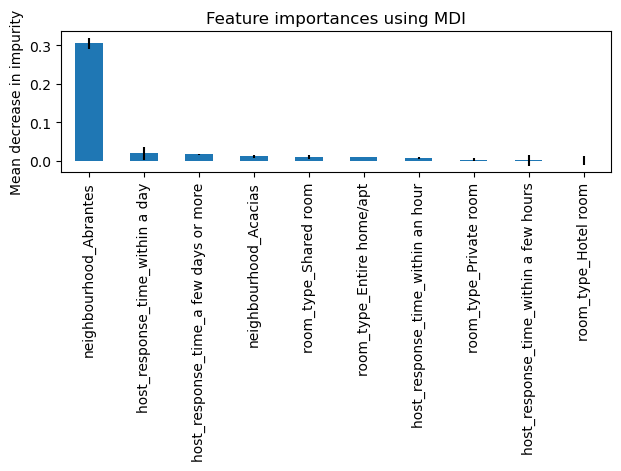

In [120]:
import numpy as np
importances = random_search.best_estimator_.steps[1][1].feature_importances_
std = np.std([tree.feature_importances_ for tree in random_search.best_estimator_.steps[1][1].estimators_], axis=0)

feature_names = oho.get_feature_names_out()[:10]
forest_importances = pd.Series(importances[:10], index=feature_names).sort_values(ascending=False)



fig, ax = plt.subplots()
forest_importances.iloc[:10].plot.bar(yerr=std[:10], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()